In [1]:
import yt
import caesar
import matplotlib.pyplot as plt
import numpy as np
import fsps
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
from readgadget.modules import header as HEAD
from readgadget.modules.common import *
from readgadget.modules.names import *
from readgadget.modules.hdf5 import *
import sys, os
import h5py

ImportError: dynamic module does not define module export function (PyInit__fsps)

In [24]:
def fsps_isochrone_data(mass, metallicity, age):
    
    metal_dict = np.array([0.000041,0.00013,0.000231,0.000411,0.000731,0.0013,
                  0.002312,0.004111,0.00731,0.013,0.023118,0.04111])
    
    iso_Z = metal_dict[np.abs(metallicity - metal_dict).argmin()]
    
    isochrone_file = '/Users/sidneylower/fsps/MIST_interp_isochrones/MIST_z'+str(iso_Z)+'.dat'
    
    isochrone = pd.read_csv(isochrone_file, delim_whitespace=True, skiprows=10, comment='#', usecols=['log10_isochrone_age_yr', 'initial_mass', 'star_mass'])
    
    #initial_mass = isochrone['initial_mass'][np.where(np.abs(np.log10(age*1.0e9) - isochrone['log10_isochrone_age_yr']).min() & np.abs(mass - isochrone['star_mass']).min())]
    
    
    age_idx = np.where(isochrone['log10_isochrone_age_yr'] == isochrone['log10_isochrone_age_yr'][np.abs(np.log10(age*1.0e9) - isochrone['log10_isochrone_age_yr']).idxmin()])[0]
    print(age_idx)
    mass_idx = np.where(isochrone['star_mass'] == isochrone['star_mass'][np.abs(mass - isochrone['star_mass']).idxmin()])[0]
    print(mass_idx)
    full_idx = list(set(age_idx) & set(mass_idx))
    print(full_idx)
    initial_mass = isochrone['initial_mass'][full_idx]
    
    return initial_mass

In [2]:
#snapshot = '/Volumes/ufrc/narayanan/s.lower/pd_runs/simba_m25n512/snap305_boxtest/filtered_snaps/snap305_galaxy003_filtered.hdf5'
caesar_snap = '/Volumes/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0305_z0.000.hdf5'

In [3]:
obj = caesar.quick_load(caesar_snap)
sim = obj
        

yt : [INFO     ] 2019-10-16 19:59:20,074 Reading /Volumes/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0305_z0.000.hdf5
yt : [INFO     ] 2019-10-16 19:59:20,216 Loading global lists
yt : [INFO     ] 2019-10-16 20:01:10,886 Loading halos
yt : [INFO     ] 2019-10-16 20:01:20,606 Loaded 83513 halos
yt : [INFO     ] 2019-10-16 20:01:20,606 Loading galaxies
yt : [INFO     ] 2019-10-16 20:01:22,054 Loaded 2463 galaxies


In [12]:
def readsnap(snap,data,ptype,**kwargs):
    h   = HEAD.Header(snap,0,kwargs)
    d,p = pollOptions(h,kwargs,data,ptype)
    h.reading = d

    #print 'reading %s.%s' % (snap,h.extension)

    f = h.f
    initUnits(h)
    
    #print 'reading %d files...' % (h.nfiles)

    for i in range(0,h.nfiles):
        if i > 0:
            h = HEAD.Header(snap,i,kwargs)
            f = h.f
            h.reading = d
            initUnits(h)

        if h.npartThisFile[p] == 0:
            if h.nfiles > 1:
                continue
            print('no %s particles present!' % pNames[p])
            sys.exit()

        if h.fileType == 'hdf5':
            arr = hdf5.hdf5_read(f,h,p)
        elif h.fileType == 'tipsy':
            arr = tipsy.tipsy_read(f,h,p)
        elif h.fileType == 'gadget1':
            arr = gadget1.gadget_read(f,h,p,d)
        elif h.fileType == 'gadget2':
            arr = gadget2.gadget_type2_read(f,h,p)

        f.close()

        ## return nth value
        if h.nth > 1:
            arr = arr[0::h.nth]

        ## put arrays together
        if i > 0:
            if len(arr) > 0:
                return_arr = np.concatenate((return_arr,arr))
        else:
            return_arr = arr
            gadgetPrinter(h,d,p)
            if h.nth > 1 and not h.suppress:
                print('selecting every %d particles' % h.nth)

        ## if requesting a single file, break out of loop
        if h.singleFile:
            break

    if h.double and h.reading != 'pid' and h.reading != 'ParticleIDs':
        return_arr = return_arr.astype(np.float64)
                                    
    return return_arr

In [13]:
def readhead(snap,data,**kwargs):
    h = HEAD.Header(snap,0,kwargs)
    h.f.close()
    pollHeaderOptions(h,data)
    if data == 'header' or data == 'Header':
        return h.header_vals
    return h.header_vals[headerTypes[data]]

In [14]:
def tage(cosmo,thubble,a):
    return thubble-cosmo.age(1./a-1).value

def get_tage(cosmo,thubble,tform):
    sa = np.asarray([tage(cosmo,thubble,i) for i in tform])
    return sa

def t_elapsed():
    return np.round(time.time()-TINIT,2)

In [4]:
params = {'fsps_sfh' : 0,
          'fsps_zcontinuous' : 1,
          'fsps_imf_type' : 2,
          'fsps_zred' : 0.0,
          'star_metal_index' : 0
        }

cosmo = FlatLambdaCDM(H0=100*sim.simulation.hubble_constant, Om0=sim.simulation.omega_matter, Ob0=sim.simulation.omega_baryon,Tcmb0=2.73)
solar_Z = 0.0196

In [5]:
fsps_ssp = fsps.StellarPopulation(sfh=params['fsps_sfh'],
                zcontinuous=params['fsps_zcontinuous'],
                imf_type=params['fsps_imf_type'],
                zred=params['fsps_zred'], add_dust_emission=False)

In [8]:
old_caesar = pd.read_pickle('/Users/sidneylower/Documents/snap305_dirichlet/caesar_galaxy_properties_evo2000.pkl')
ultra = pd.read_pickle('/Volumes/ufrc/narayanan/s.lower/simSEDs/simbam25n512_newfof/snap305_ultra/reparam_noll/prospectorsnap305_properties_Dirichlet_1570543762.1712768.pkl')

In [154]:
galaxy = 56

In [155]:
snapshot = '/Volumes/ufrc/narayanan/s.lower/pd_runs/simba_m25n512/snap305_boxtest/filtered_snaps/snap305_galaxy{:03d}'.format(galaxy)+'_filtered'


In [116]:
h = sim.simulation.hubble_constant
sm = readsnap(snapshot,'mass','star',units=1,suppress=1)#/h
tform = readsnap(snapshot,'age','star',units=1,suppress=1)  # expansion factor of formation
smetal = readsnap(snapshot,'metallicity','star',units=1,suppress=1)
thubble = cosmo.age(sim.simulation.redshift).value
sa = get_tage(cosmo,thubble,tform)

In [117]:
#fsps_years = np.arange(5.0,10.3, 0.05)
#sfr_bins = (10**fsps_years)/1.e9

sfr_bins = np.linspace(1e-4, 13.8, 130)

In [156]:
sfr = []
for i in range(len(sfr_bins)-1):
    #stellar_mass = part_mass
    #stellar_metallicity = star_metallicity[obj.galaxies[galaxy].slist]
    #star_ages = stellar_ages[obj.galaxies[galaxy].slist]
    #plist = np.array(obj.galaxies[galaxy].slist)  
    smass = sm
    sage = sa
    age_bin = np.where((sage > (sfr_bins[i])) & (sage < (sfr_bins[i+1])))[0]
    #print(age_bin)
    if len(age_bin) == 0:
        sfr_current_bin = 1.0e-10
        sfr.append(sfr_current_bin)
    else:
        current_mass = smass[age_bin]
        #current_Z = stellar_metallicity[age_bin]
        initial_mass = 0.0
        for star in age_bin:
            fsps_ssp.params["logzsol"] = np.log10(smetal[star] / solar_Z)
            mass_remaining = fsps_ssp.stellar_mass
            initial_mass += smass[star] / np.interp(np.log10(sage[star]*1.e9),fsps_ssp.ssp_ages,mass_remaining)  
            #initial_mass += fsps_isochrone_data(current_mass[star], current_Z[star].value, star_ages[star].in_units('Gyr').value)
        sfr_current_bin = initial_mass/np.abs(sfr_bins[i+1]*1e9 - sfr_bins[i]*1e9)
        sfr.append(sfr_current_bin)

In [157]:
c_timelist = list(dict.fromkeys(old_caesar.index.get_level_values('Time [Gyr]')))
c_sfrlist = old_caesar.loc[[galaxy]]['SFR']

In [158]:
ultra_timelist = list(dict.fromkeys(ultra.index.get_level_values('Time [Gyr]')))
ultra_sfrlist = list(dict.fromkeys(ultra.loc[['{0:03}'.format(galaxy)]]['SFR']))
ultra_sfr16 = list(dict.fromkeys(ultra.loc[['{0:03}'.format(galaxy)]]['SFR_16']))
ultra_sfr84 = list(dict.fromkeys(ultra.loc[['{0:03}'.format(galaxy)]]['SFR_84']))

In [121]:
simtime = obj.simulation.time.in_units('Gyr').value

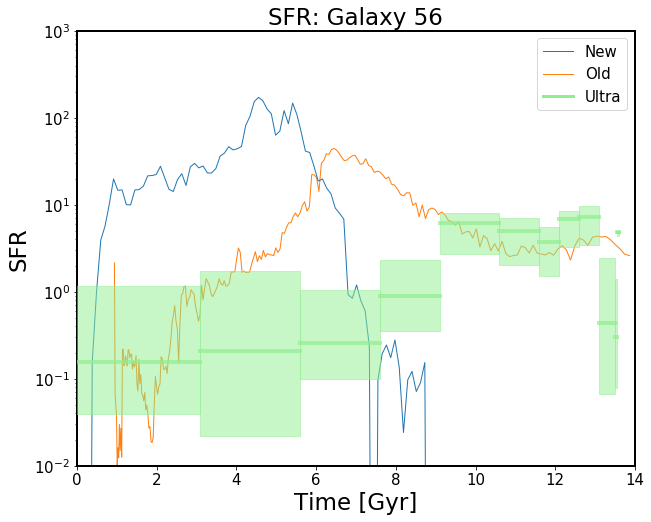

In [161]:
plt.figure(figsize=(10, 8))
plt.rc('axes', linewidth=2)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
plt.plot(simtime - sfr_bins[:len(sfr)], sfr, lw=1, label='New', zorder=1)
plt.plot(c_timelist, c_sfrlist, lw=1, label='Old', zorder=0)


for i in range(12):
    plt.plot([ultra_timelist[i], ultra_timelist[i+1]], [ultra_sfrlist[i], ultra_sfrlist[i]], color='lightgreen', lw=4, alpha=0.7, zorder=5)
    plt.fill_between([ultra_timelist[i], ultra_timelist[i+1]], y1=ultra_sfr16[i], y2=ultra_sfr84[i], color='lightgreen', alpha=0.5, zorder=5)

plt.plot([ultra_timelist[0],ultra_timelist[1]], [ultra_sfrlist[0], ultra_sfrlist[0]], color='lightgreen', lw=3, label='Ultra', zorder=5)


#plt.scatter(sfr_bins[:999], sfr)
plt.yscale('log')
plt.ylim([1e-2, 1e3])
plt.xlim([0, 14])
plt.ylabel('SFR', fontsize=23)
plt.xlabel('Time [Gyr]', fontsize=23)
plt.title('SFR: Galaxy '+str(galaxy), fontsize=23)
plt.legend(loc='best', fontsize=15)
#plt.savefig('/Users/sidneylower/Documents/prosp_final_plots/sfr_comp'+str(galaxy)+'.png', dpi=300, bbox_inches='tight')

In [273]:
fsps_ssp.params["logzsol"] = np.log10(0.00041 / solar_Z)
mass_remaining = fsps_ssp.stellar_mass

In [270]:
mass_remaining

array([0.99875146, 0.99867496, 0.99857952, 0.99843983, 0.99831209,
       0.99815737, 0.99798132, 0.99777568, 0.99753626, 0.99731347,
       0.99704951, 0.99674141, 0.99640449, 0.99635866, 0.99625915,
       0.99606837, 0.99573118, 0.99543193, 0.99495435, 0.99423779,
       0.99192614, 0.98578042, 0.97975119, 0.97426947, 0.96898328,
       0.963747  , 0.95671861, 0.94801732, 0.9387051 , 0.92899031,
       0.91888471, 0.909823  , 0.90212177, 0.89424753, 0.88648976,
       0.87949192, 0.87241046, 0.86566233, 0.85926504, 0.85286478,
       0.84656467, 0.84026319, 0.83398948, 0.82766561, 0.82134295,
       0.81488182, 0.80852059, 0.80197635, 0.79563789, 0.78932639,
       0.78289196, 0.77652123, 0.7702689 , 0.76418076, 0.7578888 ,
       0.75160348, 0.74540684, 0.73922292, 0.7331499 , 0.727076  ,
       0.72097906, 0.71519749, 0.7094304 , 0.70365291, 0.69793112,
       0.69253422, 0.68712721, 0.68177906, 0.67667712, 0.67160769,
       0.66662292, 0.66170346, 0.65655567, 0.64871952, 0.64307

In [274]:
mass_remaining

array([0.99874177, 0.99852869, 0.99845955, 0.99845138, 0.99819866,
       0.99803939, 0.99800399, 0.99764099, 0.99742067, 0.99722592,
       0.9969954 , 0.99671022, 0.99643162, 0.99642948, 0.99622986,
       0.99594721, 0.99568152, 0.99536061, 0.99537492, 0.99471835,
       0.99267441, 0.98663732, 0.97841832, 0.97305752, 0.96794509,
       0.96131281, 0.95157745, 0.94184986, 0.93354542, 0.92520826,
       0.91669684, 0.9085673 , 0.90110505, 0.89363292, 0.88618625,
       0.87931091, 0.87233277, 0.86563261, 0.85897088, 0.85251724,
       0.84590294, 0.83945905, 0.83326674, 0.82682435, 0.82036375,
       0.8138143 , 0.8072614 , 0.80060028, 0.79424633, 0.78775182,
       0.78119728, 0.77472871, 0.76826823, 0.76208464, 0.75575514,
       0.74944932, 0.7431272 , 0.73707744, 0.73077573, 0.72463612,
       0.71855696, 0.71262848, 0.70671447, 0.70076359, 0.69510404,
       0.68950122, 0.68392456, 0.67865609, 0.67343031, 0.66828787,
       0.66333757, 0.65853217, 0.65274714, 0.64559068, 0.64091

In [37]:
np.interp(np.log10(sage[star]*1.e9),fsps_ssp.ssp_ages,mass_remaining)

0.5778834497781007

In [114]:
np.log10(smetal / solar_Z)

array([-0.15570629, -0.7895461 , -0.6320924 , ...,  0.00291433,
       -1.104912  , -0.9592349 ], dtype=float32)

In [131]:
mstar0 = np.asarray([i.masses['stellar'] for i in sim.galaxies if i.central <= 1])

In [134]:
len(mstar0)

2463

In [135]:
len(sim.galaxies.masses['stellar'])

AttributeError: 'list' object has no attribute 'masses'

In [152]:
list(i.GroupID for i in sim.galaxies if i.central == 0)

[3,
 11,
 16,
 17,
 31,
 38,
 40,
 42,
 45,
 46,
 49,
 56,
 61,
 68,
 73,
 77,
 86,
 92,
 108,
 114,
 115,
 117,
 126,
 131,
 133,
 135,
 139,
 143,
 146,
 152,
 163,
 166,
 167,
 168,
 176,
 178,
 180,
 183,
 184,
 190,
 191,
 192,
 198,
 200,
 205,
 215,
 230,
 231,
 237,
 242,
 244,
 253,
 255,
 258,
 260,
 261,
 265,
 269,
 271,
 275,
 278,
 281,
 283,
 287,
 290,
 294,
 295,
 298,
 301,
 303,
 304,
 305,
 308,
 317,
 318,
 320,
 321,
 334,
 335,
 337,
 338,
 339,
 344,
 350,
 352,
 356,
 357,
 362,
 366,
 367,
 371,
 377,
 380,
 388,
 389,
 395,
 397,
 398,
 399,
 402,
 403,
 404,
 407,
 418,
 430,
 434,
 436,
 442,
 449,
 451,
 461,
 465,
 470,
 475,
 481,
 482,
 491,
 495,
 504,
 505,
 507,
 508,
 512,
 513,
 518,
 520,
 524,
 526,
 528,
 529,
 530,
 535,
 536,
 537,
 538,
 539,
 548,
 550,
 556,
 559,
 565,
 573,
 575,
 581,
 582,
 586,
 589,
 596,
 600,
 601,
 602,
 612,
 616,
 617,
 618,
 619,
 625,
 626,
 633,
 642,
 644,
 648,
 649,
 653,
 655,
 656,
 661,
 663,
 664,
 666,

In [153]:
sim.galaxies[3].central

False

AttributeError: 'list' object has no attribute 'id'

In [162]:
np.log10(sage[0]*1.e9),fsps_ssp.ssp_ages

(9.97403991525452,
 array([ 5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,  5.85,  5.9 ,
         5.95,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,  6.3 ,  6.35,
         6.4 ,  6.45,  6.5 ,  6.55,  6.6 ,  6.65,  6.7 ,  6.75,  6.8 ,
         6.85,  6.9 ,  6.95,  7.  ,  7.05,  7.1 ,  7.15,  7.2 ,  7.25,
         7.3 ,  7.35,  7.4 ,  7.45,  7.5 ,  7.55,  7.6 ,  7.65,  7.7 ,
         7.75,  7.8 ,  7.85,  7.9 ,  7.95,  8.  ,  8.05,  8.1 ,  8.15,
         8.2 ,  8.25,  8.3 ,  8.35,  8.4 ,  8.45,  8.5 ,  8.55,  8.6 ,
         8.65,  8.7 ,  8.75,  8.8 ,  8.85,  8.9 ,  8.95,  9.  ,  9.05,
         9.1 ,  9.15,  9.2 ,  9.25,  9.3 ,  9.35,  9.4 ,  9.45,  9.5 ,
         9.55,  9.6 ,  9.65,  9.7 ,  9.75,  9.8 ,  9.85,  9.9 ,  9.95,
        10.  , 10.05, 10.1 , 10.15]))